In [26]:
#multi channel CNN for sentiment analysis
from nltk.corpus import stopwords
from string import punctuation
import pandas as pd
import json
import numpy as np
import re
import word2vecReader as godin_embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.optimizers import Adam
from keras.layers.merge import concatenate
import keras.backend as K
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [5,5]
plt.style.use('seaborn-notebook')
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error,r2_score
from math import sqrt
from gensim.models import KeyedVectors
from sklearn.model_selection import KFold

In [7]:
seed = 7
np.random.seed(seed)

In [8]:
#loading data
def load_data_from_file(filename):
    print("loading file = ",filename)
    with open(filename,'r') as f:
        foo = json.load(f)
        
    sentence = []
    score = []
    for key in foo.keys():
        for info in foo[key]['info']:
#             print(eval(info['snippets'])[0])
            sentence.append(eval(info['snippets'])[0])
            score.append(float(info['sentiment_score']))
#         sentence_id.append(key)
#         sentence.append(foo[key]['sentence'])
#         score.append(float(foo[key]['info'][0]['sentiment_score']))
    return sentence,score

In [9]:
dataX,dataY = load_data_from_file('dataset/master.json')

loading file =  dataset/master.json


In [11]:
len(dataX),len(dataY)

(1171, 1171)

In [12]:
def rescale(series,old_range,new_range):
    m = interp1d(old_range,new_range)
    return [float(m(x)) for x in series]

In [13]:
dataY = rescale(dataY,[-1,1],[0,1])

In [14]:
def remove_punctuation(s):
    list_punctuation = list(punctuation.replace('$',''))
    for i in list_punctuation:
        s = s.replace(i,'')
    return s

In [15]:
def clean_sentence(sentence):
    #remove multiple repeat non num-aplha char !!!!!!!!!-->!
    sentence = re.sub(r'(\W)\1{2,}', r'\1', sentence) 
    #removes alpha char repeating more than twice aaaa->aa
    sentence = re.sub(r'(\w)\1{2,}', r'\1\1', sentence)
    #removes links
    sentence = re.sub(r'(?P<url>https?://[^\s]+)', r'', sentence)
    # remove @usernames
    sentence = re.sub(r"\@(\w+)", "", sentence)
    #removing stock names to see if it helps
#     sentence = re.sub(r"(?:\$|https?\://)\S+", "", sentence)
    #remove # from #tags
    sentence = sentence.replace('#','')
    # split into tokens by white space
    tokens = sentence.split()
    # remove punctuation from each token
    tokens = [remove_punctuation(w) for w in tokens]
#     remove remaining tokens that are not alphabetic
#     tokens = [word for word in tokens if word.isalpha()]
#no removing non alpha words to keep stock names($ZSL)
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    tokens = ' '.join(tokens)
    return tokens

In [16]:
# extract sentences out of df and cleaning it
print('cleaning data set')
dataX = [clean_sentence(x) for x in dataX]
# sentences

cleaning data set


In [18]:
dataY = np.asarray(dataY)

In [19]:
lengths = [len(s.split()) for s in dataX]
max_length = max(lengths)

In [20]:
max_length

15

(array([0.11833598, 0.1616445 , 0.26656094, 0.07624741, 0.04452849,
        0.04086861, 0.00243992, 0.0030499 , 0.        , 0.00060998]),
 array([ 1. ,  2.4,  3.8,  5.2,  6.6,  8. ,  9.4, 10.8, 12.2, 13.6, 15. ]),
 <a list of 10 Patch objects>)

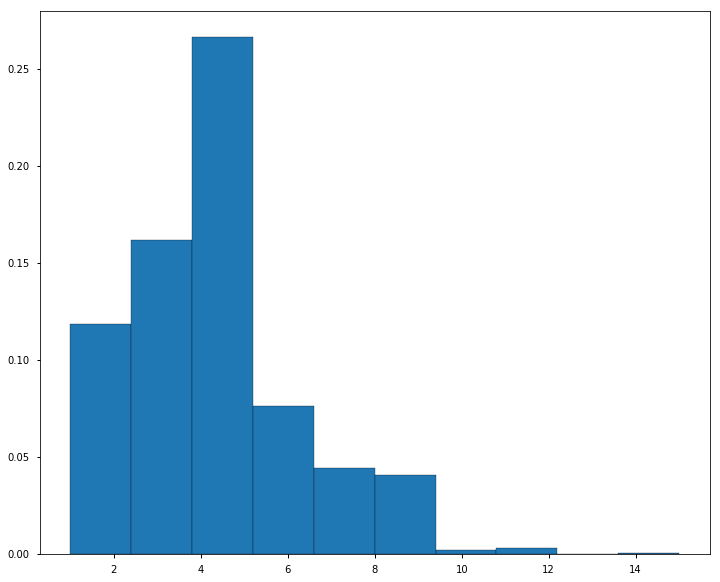

In [22]:
plt.subplots(figsize=(12,10))
plt.hist(lengths, normed=True,edgecolor='black')

In [27]:
# kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

In [29]:
#loading Google Word2Vec
def load_google_word2vec(file_name):
    return KeyedVectors.load_word2vec_format(file_name, binary=True)

In [30]:
word2vec_model= load_google_word2vec('word_embeddings/GoogleNews-vectors-negative300.bin')

In [31]:
#loading godin word embedding
def load_godin_word_embedding(path):
    print("Loading the model, this can take some time...")
    return godin_embedding.Word2Vec.load_word2vec_format(path, binary=True)

In [32]:
godin_model = load_godin_word_embedding("word_embeddings/word2vec_twitter_model.bin")

Loading the model, this can take some time...


In [33]:
def get_embedding_matrix(model,sentence,godin_flag = False):
    tokens = sentence.split()[:max_length]
    if godin_flag:
        embedding_matrix = np.zeros((max_length,400))
    else:
        embedding_matrix = np.zeros((max_length,300))
    for i,word in enumerate(tokens):
        try:
            embedding_vector = model[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector
    return embedding_matrix

In [34]:
print("bulding word2vec matrix of data set")
data_word2vec = np.asarray([get_embedding_matrix(word2vec_model,x) for x in dataX])
print("bulding godin matrix of data set")
data_godin = np.asarray([get_embedding_matrix(godin_model,x,godin_flag=True) for x in dataX])

bulding word2vec matrix of data set
bulding godin matrix of data set


In [39]:
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

In [42]:
def sk_mse(y_true,y_pred):
     return K.mean(K.square(y_pred - y_true), axis=-1)

In [54]:
def define_model(length,n_dense,dropout,learning_rate,n_filters,filter_size_c1,filter_size_c2,filter_size_c3,em_c1,em_c2,em_c3):
    # channel 1
    if em_c1 == 'embedding_matrix_word2vec':
        inputs1 = Input(shape=(length,300))
    else:
        inputs1 = Input(shape=(length,400))
#     if em_c1 == 'free':
#         embedding1 = Embedding(vocab_size, free_em_dim)(inputs1)
#     else:
#         embedding1 = Embedding(vocab_size, len(eval(em_c1)[0]), weights = [eval(em_c1)],input_length=length,trainable = em_trainable_flag)(inputs1)

    conv1 = Conv1D(filters=n_filters, kernel_size=filter_size_c1, activation='relu')(inputs1)
    drop1 = Dropout(dropout)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    # channel 2
    if em_c2 == 'embedding_matrix_word2vec':
        inputs2 = Input(shape=(length,300))
    else:
        inputs2 = Input(shape=(length,400))
#     embedding2 = Embedding(vocab_size, 400, weights = [embedding_matrix_godin],input_length=length,trainable = em_trainable_flag)(inputs2)
#     if em_c2 == 'free':
#         embedding2 = Embedding(vocab_size, free_em_dim)(inputs2)
#     else:
#         embedding2 = Embedding(vocab_size, len(eval(em_c2)[0]), weights = [eval(em_c2)],input_length=length,trainable = em_trainable_flag)(inputs2)
    conv2 = Conv1D(filters=n_filters, kernel_size=filter_size_c2, activation='relu')(inputs2)
    drop2 = Dropout(dropout)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)
    # channel 3
    if em_c1 == 'embedding_matrix_word2vec':
        inputs3 = Input(shape=(length,300))
    else:
        inputs3 = Input(shape=(length,400))
#     embedding3 = Embedding(vocab_size, 400)(inputs3)
#     if em_c3 == 'free':
#         embedding3 = Embedding(vocab_size, free_em_dim)(inputs3)
#     else:
#         embedding3 = Embedding(vocab_size, len(eval(em_c3)[0]), weights = [eval(em_c3)],input_length=length,trainable = em_trainable_flag)(inputs3)
    conv3 = Conv1D(filters=n_filters, kernel_size=filter_size_c3, activation='relu')(inputs3)
    drop3 = Dropout(dropout)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)
    # merge
    merged = concatenate([flat1, flat2, flat3])
    # interpretation
    dense1 = Dense(n_dense, activation='relu')(merged)
    outputs = Dense(1, activation='sigmoid')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    # compile
    optimizer = Adam(lr=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[sk_mse])
    # summarize
#     print(model.summary())
#     plot_model(model, show_shapes=True, to_file='multichannel.png')
    return model

In [45]:
cv_mse =[]

In [46]:
cv_r2 = []

In [56]:
for train,test in kfold.split(dataX,dataY):
    model = define_model(length = max_length,
                         n_dense=400,
                         dropout=0.9,
                         learning_rate=0.0006973763486468701,
                         n_filters=300,
                         filter_size_c1=1,
                         filter_size_c2=1,
                         filter_size_c3=1,
                         em_c1='embedding_matrix_godin',
                         em_c2='embedding_matrix_word2vec',
                         em_c3='embedding_matrix_godin')
    input_array_train = [data_godin[train],data_word2vec[train],data_godin[train]]
    input_array_test = [data_godin[test],data_word2vec[test],data_godin[test]]
    trainY = dataY[train]
    testY = dataY[test]
    history_object = model.fit(input_array_train,trainY,epochs=30, batch_size=8,verbose=0)
    pred = model.predict(input_array_test)
    pred_val = [x[0] for x in pred]
    pred_val = rescale(pred_val,[0,1],[-1,1])
    testY = rescale(testY,[0,1],[-1,1])
    m = mean_squared_error(testY,pred_val)
    r2 = r2_score(testY,pred_val)
    print(m,r2)
    cv_mse.append(m)
    cv_r2.append(r2)

0.10343218728427603 0.3093617125885538
0.11082901716092575 0.3214193870990977
0.10922397337212918 0.2996706946188652
0.12080560219923858 0.27274889295718263
0.10764737821782466 0.3265275466674228


In [61]:
print("%.5f (+/- %.5f)" % (np.mean(cv_mse), np.std(cv_mse)))

0.11039 (+/- 0.00576)


In [62]:
print("%.5f (+/- %.5f)" % (np.mean(cv_r2), np.std(cv_r2)))

0.30595 (+/- 0.01906)


In [47]:
# input_array_train = [train_godin,train_word2vec,train_godin]
# input_array_test = [test_godin,test_word2vec,test_godin]

In [48]:
# history_object = model.fit(input_array_train, trainY,epochs=30, batch_size=8)

In [421]:
# pred = model.predict(input_array_test)

In [422]:
# pred_val = [x[0] for x in pred]

In [424]:
# pred_val = rescale(pred_val)
# testY = rescale(testY)

In [49]:
# mean_squared_error(testY,pred_val)

In [50]:
# r2_score(testY,pred_val)

In [51]:
# for i,y in zip(pred_val,testY):
#     print(i,y)

In [52]:
# plt.hist(pred_val)

In [53]:
# plt.hist(testY)